# Deep Learning NLP Recommender Challenge - Modeling

Amanda Cheney  
Part 2 of 2  
March 1, 2021

#### Objective  
Construct a deep learning network using NLP techniques that is able to predict whether a user will click on an unseen news article. The model should take as input user-news items and output a binary variable (1/0).  

#### This Notebook  
Uses FastAI to construct language model and classifer that predicts user-news interactions with 96% precision.

### Imports

In [1]:
import numpy as np
import pandas as pd 
import pickle 
from sklearn.model_selection import train_test_split

from fastai import * 
from fastai.text import * 
from fastai.callbacks import *

# Avoid warnings
import warnings
warnings.filterwarnings("ignore")

### Load Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
with open('/content/drive/MyDrive/inspire_challenge/full_df.pickle', 'rb') as read_file:
    df = pickle.load(read_file)

In [4]:
df.head()

,user_id,news_id,title,abstract,target
0,U100,N10121,Disney+ isn't working for some users on launch...,"Like most new online services, it looks like D...",0
1,U100,N10532,Advocacy groups push Senate to include electio...,A group of advocacy organizations is pushing t...,0
2,U100,N11813,"Angels GM hinting at going after Gerrit Cole, ...",With payroll flexibility and the need to add a...,0
3,U100,N11856,Pro Russian hockey team tweets it wants fired ...,HC Dynamo Moscow of the KHL tweeted Tuesday th...,0
4,U100,N13827,DIY Closet Organization Ideas That Will Make G...,Getting dressed in the morning has never been ...,0


### Train/Test Split  
Split data into train and test. Note that since we are using fastai, we do not need to do an additional validation split at this point, as that will be done later when we build the classification model. Before we do that, however, we must first build our language model.

In [5]:
train, test = train_test_split(df, test_size=0.2, random_state=44, stratify=df['target'])

In [6]:
train.target.value_counts(normalize=True)

0    0.805182
1    0.194818
Name: target, dtype: float64

In [7]:
test.target.value_counts(normalize=True)

0    0.805183
1    0.194817
Name: target, dtype: float64

### Language Model  
To conduct any NLP analyis, the first step is to convert text data a list of tokens and then convert those tokens into some kind of numeric representation. I use fast.ai's `Data Block API` for these tasks, which it more or less does these preprocessing tasks under the hood.   
In the following call we do the following:  
1. Import data from our training data DataFrame and tell the model to use `abstract` and `title` as input. 
2. Split the training dataset into train/validation sets by random 20/80 percent.
3. Implictly ignore the given labels and instead use the language model's 'predict next word' as labels 
4. Build the data into a `databunch` with batch size = 48.   

The `databunch` that we create here will later be fed to our language model in the coming steps.


In [8]:
%%time
data_lm = TextList.from_df(train[['title','abstract']]).split_by_rand_pct(0.2).label_for_lm().databunch(bs=48)

CPU times: user 1min 13s, sys: 1min 7s, total: 2min 21s
Wall time: 11min 47s


Let's have a look at the `databunch` we just built to see that the tokenization looks okay on the training set.

In [9]:
data_lm.show_batch()

idx,text
0,"xxbos xxmaj the most exclusive hotel in every state xxbos xxmaj pope blasts ' inhuman , un - xxmaj christian ' rebirth of anti - xxmaj semitism xxbos xxmaj entire xxmaj oklahoma and xxmaj texas teams get unsportsmanlike conduct penalties before xxmaj red xxmaj river xxmaj showdown xxbos xxmaj powell 's xxmaj warning to xxmaj congress xxmaj about the xxmaj next xxmaj recession xxbos xxmaj see the most expensive watch"
1,"xxmaj for the first time ever , a xxup us cheese is named best in the world xxbos ' xxmaj do n't stay silent ' : xxmaj democrats lash out as xxup gop blocks gun measure amid school shooting xxbos a $ 30,000 handbag . a disastrous wine spill . xxmaj and now , a country club is suing its own waiter . xxbos xxmaj freshman finds 1966 calendar behind"
2,mainstays from xxmaj your xxmaj childhood xxmaj that xxmaj you xxmaj wo n't xxmaj find in xxmaj new xxmaj homes xxbos xxmaj bands ' final albums before they broke up xxbos xxmaj century xxmaj links 11 / 9 : xxmaj how xxmaj can xxmaj seahawks xxmaj improve on xxmaj defense ? xxbos xxmaj wealthy investors are bracing for a sharp stock sell - off in 2020 xxbos xxup us held
3,"me xxmaj fall in xxmaj love xxmaj with ... xxmaj beets xxbos xxmaj this xxmaj guy xxmaj lost 30 xxmaj pounds and xxmaj gained a xxmaj rock - xxmaj hard xxmaj six xxmaj pack xxbos xxmaj in xxmaj less xxmaj than a xxmaj decade , xxmaj you xxmaj wo n't xxmaj be xxmaj able xxmaj to xxmaj afford a xxmaj home in xxmaj these xxmaj cities xxbos xxmaj stunning photos"
4,"market , ex - xxup fda adviser says xxbos xxmaj georgia executes man convicted of killing convenience store clerk xxbos xxmaj one of xxmaj america 's biggest solar panel makers quits manufacturing xxbos 40 xxmaj restaurant xxmaj meals xxmaj you xxmaj should xxmaj never xxmaj eat xxmaj after 40 xxbos xxmaj the xxmaj full - xxmaj size 2022 xxmaj jeep xxmaj grand xxmaj wagoneer xxup suv xxmaj is xxmaj finally"


The xx___ tags represent the aspects of language in a way that the computer can understand. The xxbos tag marks the beginning of a sentence. The xxmaj tag is used to imply that the first letter of the next word is capitalized.

### Model Architecture   
Now we will use our `data_lm` databunch to make our language model. First we put our `data_lm` databunch into a `language_model_learner`, tell it that we want to use `AWD_LSTM` for the architecture our language model, and assign a default dropout rate of 0.3.

`AWD-LSTM` is a pre-trained language model trained on Wikipedia text data (Wikitext-103). While theoretically, we could directly use this pre-trained language model to build our news classifier, the language used in news headlines and abstracts is somewhat different from the language of Wikipedia. FastAI allows us to fine-tune this pre-trained language model using our news abstract and title data and then build our classifier on top of that to create our own language model. 

The language model we are building here, is being trained to guess the next word starting from a sequence of words as input. It has a recurrent structure and a hidden state that is updated each time it sees a new word. While simple RNN's suffer from the exploding gradients, using LSTM (Long Short Term Memory) helps avoid this problem as it has a unique way of computing the hidden state and is capable of learning long-term dependencies. The AWD aspect of the AWD-LSTM architecture (which stands for **A**SGD **W**eight **D**ropped  (ASGB stands for **A**veraged **S**tochastic **G**radient **D**escent)) takes a regular LSTM with several layers and adds on additional regularization using various types of dropouts which discard partial information of the weight matriculates between the hidden states to avoid overfitting. 

In [10]:
%%time
learn = language_model_learner(data_lm,AWD_LSTM, drop_mult=0.3)

CPU times: user 2.85 s, sys: 531 ms, total: 3.38 s
Wall time: 6.93 s


In [11]:
%%time
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
CPU times: user 16.6 s, sys: 2.96 s, total: 19.6 s
Wall time: 19.7 s


From the `LR Finder` graph below, we now identify the the biggest downward slope and pick the middle point as our learning rate. 

Min numerical gradient: 1.00E-01
Min loss divided by 10: 6.31E-02


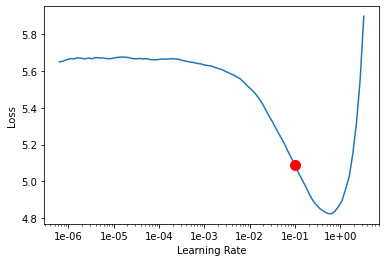

In [12]:
learn.recorder.plot(suggestion=True)

Now, we use this learning rate to train the language model.

In [13]:
%%time
learn.fit_one_cycle(1, 1e-1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.821538,0.691408,0.881484,26:07


CPU times: user 16min 16s, sys: 10min 7s, total: 26min 23s
Wall time: 26min 9s


Next we'll unfreeze the model, train/fit more, and using callbacks to select the best model.  

In [14]:
from fastai.callbacks import *

In [15]:
%%time
callback = SaveModelCallback(learn,monitor="accuracy", mode="max", name="best_lang_model")

CPU times: user 83 µs, sys: 53 µs, total: 136 µs
Wall time: 140 µs


Once the initial round of training is completed, we unfreeze the model and continue to fine tune for 4 epochs until I reached an accuracy of 90.9%. That means that in 90% of cases, my model is able to correctly predict the next word. 

Note that since this is only the language model, and not the classifier, we are using accuracy to evaluate model performance.

In [16]:
learn.unfreeze()

In [17]:
%%time
learn.fit_one_cycle(4, 1e-2, moms=(0.8,0.7), callbacks=[callback])

epoch,train_loss,valid_loss,accuracy,time
0,0.749731,0.702699,0.876668,30:49
1,0.641435,0.607698,0.891715,31:03
2,0.555330,0.528259,0.904311,31:12
3,0.518325,0.499662,0.909065,31:13


Better model found at epoch 0 with accuracy value: 0.8766677975654602.
Better model found at epoch 1 with accuracy value: 0.8917152285575867.
Better model found at epoch 2 with accuracy value: 0.9043110013008118.
Better model found at epoch 3 with accuracy value: 0.9090647101402283.
CPU times: user 1h 18min 6s, sys: 47min 23s, total: 2h 5min 29s
Wall time: 2h 4min 30s


Now we save all of our model except the final layer that converts activations to probabilities of picking each token in our vocabulary. The model not including the final layer is called the *encoder*. 

In [18]:
learn.save('fine_tuned')

In [19]:
learn.save_encoder('fine_tuned_enc')

--------

## **Classification Model**

Now to turn to the task of building our classfier.  

The very first step is to specify our test data (creating a databunch just as we have previously) which we will then reference in the subsequent call which does the following:  

1. Import data from our training data DataFrame and tell the model to use `abstract` and `title` as input. 
2. Keep the vocabulary the same as we used in the language model databunch 
3. Split the training dataset into train/validation sets by random 20/80 percent.
4. Specify our labels as the `target` column 
5. Incorporate our test data `test_datalist` with the `add_test` parameter 
6. Build the data into a `databunch` with batch size = 64.   



In [20]:
test_datalist = TextList.from_df(test, cols=['title','abstract'], vocab=data_lm.vocab)

In [21]:
data_clas = (TextList.from_df(train, cols=['title','abstract'], vocab=data_lm.vocab)
             .split_by_rand_pct(0.2)
             .label_from_df('target')
             .add_test(test_datalist)
             .databunch(bs=64))

Let's have a look at the `databunch` we just built for our classification model to see that the tokenization looks okay on the test set.


In [22]:
## check test set looks ok
data_clas.show_batch(ds_type=DatasetType.Test)

text,target
"xxbos xxmaj sex , xxmaj drugs and xxmaj ashton xxmaj kutcher : 10 xxmaj revelations xxmaj from xxmaj demi xxmaj moore 's xxmaj book xxmaj real talk . xxmaj demi xxmaj moore got candid about a variety of topics in her new book , xxmaj inside xxmaj out , including her famous exes , substance abuse struggles and her heartbreaking sexual assault . "" xxmaj the same question kept going",0
"xxbos ' xxmaj yabba xxmaj dabba xxmaj doo ! ' xxmaj kimye and xxmaj kids xxmaj rock xxmaj flintstone xxmaj halloween xxmaj costumes xxmaj fall family fun ! xxmaj kim xxmaj kardashian , xxmaj kanye xxmaj west and their kids went all out with xxunk xxmaj flintstone family costumes for xxmaj halloween . "" xxmaj yabba xxmaj dabba xxmaj doo ! "" the xxmaj keeping xxmaj up xxmaj with the",0
"xxbos ' xxmaj yabba xxmaj dabba xxmaj doo ! ' xxmaj kimye and xxmaj kids xxmaj rock xxmaj flintstone xxmaj halloween xxmaj costumes xxmaj fall family fun ! xxmaj kim xxmaj kardashian , xxmaj kanye xxmaj west and their kids went all out with xxunk xxmaj flintstone family costumes for xxmaj halloween . "" xxmaj yabba xxmaj dabba xxmaj doo ! "" the xxmaj keeping xxmaj up xxmaj with the",0
"xxbos ' xxmaj yabba xxmaj dabba xxmaj doo ! ' xxmaj kimye and xxmaj kids xxmaj rock xxmaj flintstone xxmaj halloween xxmaj costumes xxmaj fall family fun ! xxmaj kim xxmaj kardashian , xxmaj kanye xxmaj west and their kids went all out with xxunk xxmaj flintstone family costumes for xxmaj halloween . "" xxmaj yabba xxmaj dabba xxmaj doo ! "" the xxmaj keeping xxmaj up xxmaj with the",0
"xxbos ' xxmaj yabba xxmaj dabba xxmaj doo ! ' xxmaj kimye and xxmaj kids xxmaj rock xxmaj flintstone xxmaj halloween xxmaj costumes xxmaj fall family fun ! xxmaj kim xxmaj kardashian , xxmaj kanye xxmaj west and their kids went all out with xxunk xxmaj flintstone family costumes for xxmaj halloween . "" xxmaj yabba xxmaj dabba xxmaj doo ! "" the xxmaj keeping xxmaj up xxmaj with the",0


Now we’ll build the classifier using the same encoder as our language model.   
#### Evaluation Metrics 
Here we al
so have the opportunity to specify evaluation metrics. In addition to accuracy, I'm also interested in recall, precision and FBeta. I've set FBeta = 0.5 because, while both precision and recall are important, I put more emphasis on precision than recall - particularlly given the class imbalance and business use case as discussed in the first notebook. Emphasizing precision means punishing false positives more than false negatives. Here, a false positive would be a non-clicked article being labelled as clicked. In the context of a news recommender, this is important because we wouldn't want to show a user and article that they would not click on. 

In [23]:
%%time
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, metrics=[accuracy, Recall(), Precision(), FBeta(beta=.5)])

learn.load_encoder('fine_tuned_enc')

CPU times: user 869 ms, sys: 194 ms, total: 1.06 s
Wall time: 989 ms


Once again we look for the optimal learning rate for our initial round of training.

In [24]:
%%time
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,recall,precision,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
CPU times: user 2min 4s, sys: 4.41 s, total: 2min 8s
Wall time: 2min 6s


Min numerical gradient: 1.20E-01
Min loss divided by 10: 3.63E-02
CPU times: user 17.6 ms, sys: 1.52 ms, total: 19.1 ms
Wall time: 18.5 ms


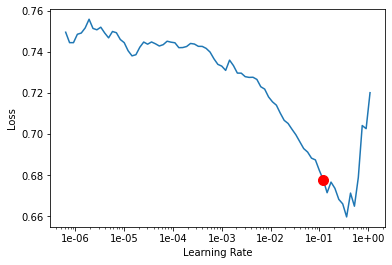

In [25]:
%%time
learn.recorder.plot(suggestion=True)

In [26]:
learn.fit_one_cycle(1, 1e-01, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,recall,precision,f_beta,time
0,0.401630,0.379245,0.833395,0.190381,0.812964,0.491502,31:30


Now we unfreeze the last 2 layers and train for one cycle - this gives a huge boost to all of our evaluation metrics.

In [27]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,recall,precision,f_beta,time
0,0.224567,0.189299,0.942594,0.735672,0.961159,0.905642,35:41


Unfreeze the last 3 layers now and train again for one more cyle.

In [28]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,recall,precision,f_beta,time
0,0.276522,0.188588,0.943253,0.736519,0.964380,0.908186,54:20


Now we will use callbacks to select the best classification model out of the given epochs in the subsequent fine tuning.

In [29]:
callbacks = SaveModelCallback(learn, monitor="Precision", mode="max", name="best_classification_model")

But first, here's a glimpse of our results at this point.

In [30]:
learn.show_results()

text,target,prediction
"xxbos xxmaj sex , xxmaj drugs and xxmaj ashton xxmaj kutcher : 10 xxmaj revelations xxmaj from xxmaj demi xxmaj moore 's xxmaj book xxmaj real talk . xxmaj demi xxmaj moore got candid about a variety of topics in her new book , xxmaj inside xxmaj out , including her famous exes , substance abuse struggles and her heartbreaking sexual assault . "" xxmaj the same question kept going",1,0
"xxbos ' xxmaj yabba xxmaj dabba xxmaj doo ! ' xxmaj kimye and xxmaj kids xxmaj rock xxmaj flintstone xxmaj halloween xxmaj costumes xxmaj fall family fun ! xxmaj kim xxmaj kardashian , xxmaj kanye xxmaj west and their kids went all out with xxunk xxmaj flintstone family costumes for xxmaj halloween . "" xxmaj yabba xxmaj dabba xxmaj doo ! "" the xxmaj keeping xxmaj up xxmaj with the",1,1
"xxbos ' xxmaj yabba xxmaj dabba xxmaj doo ! ' xxmaj kimye and xxmaj kids xxmaj rock xxmaj flintstone xxmaj halloween xxmaj costumes xxmaj fall family fun ! xxmaj kim xxmaj kardashian , xxmaj kanye xxmaj west and their kids went all out with xxunk xxmaj flintstone family costumes for xxmaj halloween . "" xxmaj yabba xxmaj dabba xxmaj doo ! "" the xxmaj keeping xxmaj up xxmaj with the",1,1
"xxbos ' xxmaj yabba xxmaj dabba xxmaj doo ! ' xxmaj kimye and xxmaj kids xxmaj rock xxmaj flintstone xxmaj halloween xxmaj costumes xxmaj fall family fun ! xxmaj kim xxmaj kardashian , xxmaj kanye xxmaj west and their kids went all out with xxunk xxmaj flintstone family costumes for xxmaj halloween . "" xxmaj yabba xxmaj dabba xxmaj doo ! "" the xxmaj keeping xxmaj up xxmaj with the",1,1
"xxbos ' xxmaj yabba xxmaj dabba xxmaj doo ! ' xxmaj kimye and xxmaj kids xxmaj rock xxmaj flintstone xxmaj halloween xxmaj costumes xxmaj fall family fun ! xxmaj kim xxmaj kardashian , xxmaj kanye xxmaj west and their kids went all out with xxunk xxmaj flintstone family costumes for xxmaj halloween . "" xxmaj yabba xxmaj dabba xxmaj doo ! "" the xxmaj keeping xxmaj up xxmaj with the",1,1


For the final fine tuning we unfreeze all the layers and train for 3 epochs. Having already reached very high performance in previous training rounds, improvements here are somewhat marginal.

In [31]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7), callbacks=[callbacks])

epoch,train_loss,valid_loss,accuracy,recall,precision,f_beta,time
0,0.264991,0.190445,0.942365,0.743460,0.950534,0.900378,1:15:48
1,0.222628,0.187756,0.943670,0.741195,0.961424,0.907496,1:19:02
2,0.191943,0.184952,0.944512,0.742678,0.965033,0.910512,1:13:43


In [33]:
# Export the model and save it for inference
learn.export("user_news_classifier.pkl")

In [35]:
learn.show_results()

text,target,prediction
"xxbos xxmaj sex , xxmaj drugs and xxmaj ashton xxmaj kutcher : 10 xxmaj revelations xxmaj from xxmaj demi xxmaj moore 's xxmaj book xxmaj real talk . xxmaj demi xxmaj moore got candid about a variety of topics in her new book , xxmaj inside xxmaj out , including her famous exes , substance abuse struggles and her heartbreaking sexual assault . "" xxmaj the same question kept going",1,0
"xxbos ' xxmaj yabba xxmaj dabba xxmaj doo ! ' xxmaj kimye and xxmaj kids xxmaj rock xxmaj flintstone xxmaj halloween xxmaj costumes xxmaj fall family fun ! xxmaj kim xxmaj kardashian , xxmaj kanye xxmaj west and their kids went all out with xxunk xxmaj flintstone family costumes for xxmaj halloween . "" xxmaj yabba xxmaj dabba xxmaj doo ! "" the xxmaj keeping xxmaj up xxmaj with the",1,1
"xxbos ' xxmaj yabba xxmaj dabba xxmaj doo ! ' xxmaj kimye and xxmaj kids xxmaj rock xxmaj flintstone xxmaj halloween xxmaj costumes xxmaj fall family fun ! xxmaj kim xxmaj kardashian , xxmaj kanye xxmaj west and their kids went all out with xxunk xxmaj flintstone family costumes for xxmaj halloween . "" xxmaj yabba xxmaj dabba xxmaj doo ! "" the xxmaj keeping xxmaj up xxmaj with the",1,1
"xxbos ' xxmaj yabba xxmaj dabba xxmaj doo ! ' xxmaj kimye and xxmaj kids xxmaj rock xxmaj flintstone xxmaj halloween xxmaj costumes xxmaj fall family fun ! xxmaj kim xxmaj kardashian , xxmaj kanye xxmaj west and their kids went all out with xxunk xxmaj flintstone family costumes for xxmaj halloween . "" xxmaj yabba xxmaj dabba xxmaj doo ! "" the xxmaj keeping xxmaj up xxmaj with the",1,1
"xxbos ' xxmaj yabba xxmaj dabba xxmaj doo ! ' xxmaj kimye and xxmaj kids xxmaj rock xxmaj flintstone xxmaj halloween xxmaj costumes xxmaj fall family fun ! xxmaj kim xxmaj kardashian , xxmaj kanye xxmaj west and their kids went all out with xxunk xxmaj flintstone family costumes for xxmaj halloween . "" xxmaj yabba xxmaj dabba xxmaj doo ! "" the xxmaj keeping xxmaj up xxmaj with the",1,1


## Model Performance

With a final precision score of 96.5% our model is performing very well. Looking at the final model's confusion matrix, however, we see that much of this performance is still being driven by the majority ('no click') class. 26% of 'clicked' articles are still being mis-labelled as not clicked. While we have not prioritized recall as an evaluation metric, ideally in future work, we would be able to arrive at even higher scores than what we have produced here. One key element would be to take additional steps to ensure proportional class representation within FastAI's train-validation split within the classifier. This functionality is not built into the FastAI, however, with additional time, it would likely be possible to work around this using sklearn. 

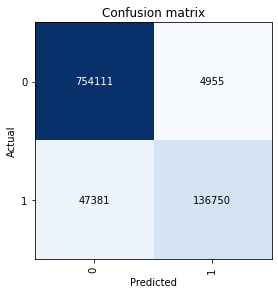

In [36]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)
interp.plot_confusion_matrix()

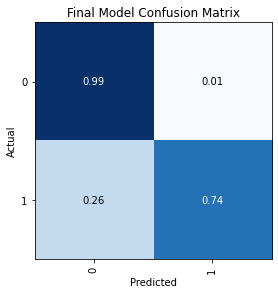

In [42]:
conf_matrix = interp.plot_confusion_matrix(normalize=True, title="Final Model Confusion Matrix", return_fig=True)

In [44]:
conf_matrix.savefig('conf_matrix.png')